### 运行说明：
### 该笔记需要python环境，环境中需确保有pytorch(cuda included)  matplotlib  sklearn  pandas  numpy库

==============================================================================================================================================================

### 利用神经网络对加州房价数据进行回归训练，预测其中位数价格

数据集特征

MedInc: 区域内家庭的中位收入。

HouseAge: 房屋的中位年龄。

AveRooms: 每个家庭的平均房间数。

AveBedrms: 每个家庭的平均卧室数。

Population: 区域内总人口。

AveOccup: 平均家庭居住人数。

Latitude: 区域的纬度。

Longitude: 区域的经度。

所求目标是房屋的中位数价值。

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [3]:
#从sklearn中下载相关数据集
california_data = fetch_california_housing()

In [4]:
data = pd.DataFrame(california_data["data"], columns=california_data.feature_names)
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [5]:
data["Target"] = california_data['target']
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [6]:
print(california_data.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [7]:
print(california_data.target_names)

['MedHouseVal']


In [8]:
# 将数据集分为特征（X）和目标（y）
X = data.drop("Target", axis=1).values
y = data["Target"].values

In [9]:
# 检查并使用gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
# 将数据集分为训练集和验证集，测试集占 20%。
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# 转换为张量
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

In [11]:
# 神经网络模型
class CaliforniaHousingNN(nn.Module):
    def __init__(self):
        super(CaliforniaHousingNN, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
#模型训练函数定义
model = CaliforniaHousingNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=100):
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
        model.train()

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return train_losses, val_losses

Epoch [10/600], Train Loss: 6.0512, Val Loss: 5.8891
Epoch [20/600], Train Loss: 5.3163, Val Loss: 5.1306
Epoch [30/600], Train Loss: 4.1016, Val Loss: 3.8719
Epoch [40/600], Train Loss: 2.5218, Val Loss: 2.3112
Epoch [50/600], Train Loss: 1.5512, Val Loss: 1.4580
Epoch [60/600], Train Loss: 1.2728, Val Loss: 1.1933
Epoch [70/600], Train Loss: 0.9733, Val Loss: 0.9385
Epoch [80/600], Train Loss: 0.8328, Val Loss: 0.8205
Epoch [90/600], Train Loss: 0.7497, Val Loss: 0.7550
Epoch [100/600], Train Loss: 0.7043, Val Loss: 0.7155
Epoch [110/600], Train Loss: 0.6667, Val Loss: 0.6800
Epoch [120/600], Train Loss: 0.6315, Val Loss: 0.6464
Epoch [130/600], Train Loss: 0.5993, Val Loss: 0.6168
Epoch [140/600], Train Loss: 0.5702, Val Loss: 0.5906
Epoch [150/600], Train Loss: 0.5441, Val Loss: 0.5669
Epoch [160/600], Train Loss: 0.5214, Val Loss: 0.5457
Epoch [170/600], Train Loss: 0.5014, Val Loss: 0.5265
Epoch [180/600], Train Loss: 0.4843, Val Loss: 0.5095
Epoch [190/600], Train Loss: 0.4698, 

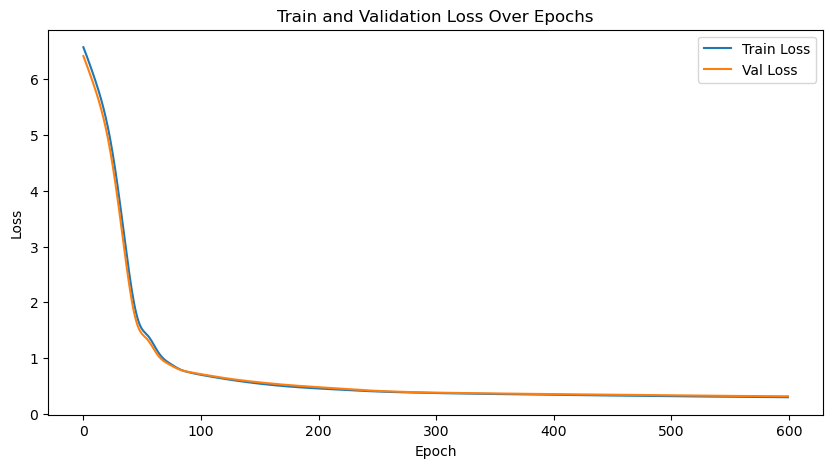

In [13]:
# 可视化损失
train_losses, val_losses = train(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=600)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [14]:
# 计算并查看 RMSE
model.eval()
with torch.no_grad():
    train_predictions = model(X_train)
    train_mse = criterion(train_predictions, y_train)
    train_rmse = torch.sqrt(train_mse)

    val_predictions = model(X_val)
    val_mse = criterion(val_predictions, y_val)
    val_rmse = torch.sqrt(val_mse)

    print(f'Final Train RMSE: {train_rmse.item():.4f}')
    print(f'Final Val RMSE: {val_rmse.item():.4f}')

Final Train RMSE: 0.5468
Final Val RMSE: 0.5623


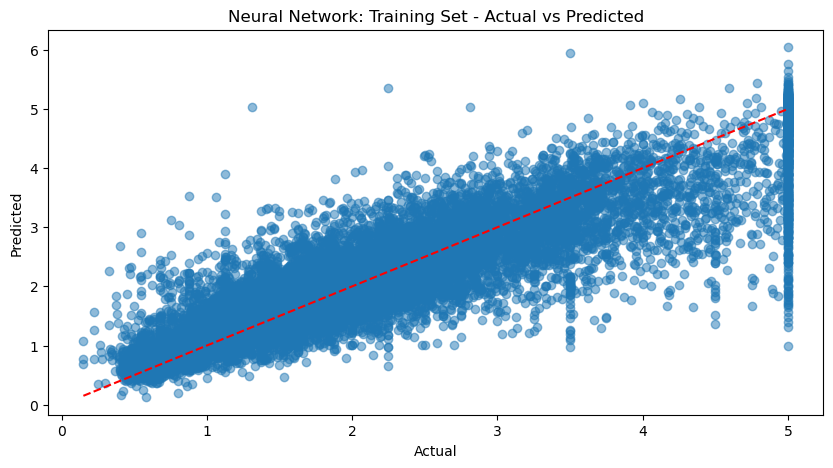

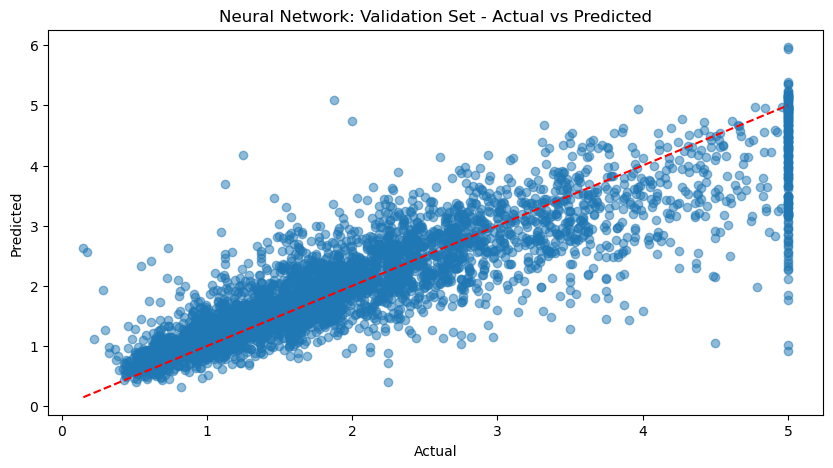

In [16]:
# 转换预测值为CPU上的NumPy数组
train_predictions_nn = train_predictions.cpu().numpy()
val_predictions_nn = val_predictions.cpu().numpy()
y_train = y_train.cpu()
X_train = X_train.cpu()
y_val = y_val.cpu()
X_val = X_val.cpu()

# 绘制训练集预测值与真实值
plt.figure(figsize=(10, 5))
plt.scatter(y_train.cpu().numpy(), train_predictions_nn, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Neural Network: Training Set - Actual vs Predicted')
plt.show()

# 绘制验证集预测值与真实值
plt.figure(figsize=(10, 5))
plt.scatter(y_val.cpu().numpy(), val_predictions_nn, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Neural Network: Validation Set - Actual vs Predicted')
plt.show()